# Vector data in Arraylake  

This demo will setup answering the problem we just stated... 

General patterns for working with vector data in Arraylake.
Three main components:
1. Write vector data cube to Zarr store
2. Sample raster data cube at set of **point** geometries
3. Sample and compute zonal statistics for raster data cube with set of **polygon** geometries

## Utility fns + setup

In [2]:
import duckdb
import geopandas as gpd
from IPython.display import Image

# create duckdb connection
conn = duckdb.connect()

# load extensions
conn.load_extension("spatial")
conn.load_extension("httpfs")

# specify aws region
conn.execute("SET s3_region='us-west-2'");

In [3]:
def overture_query(query: str) -> gpd.GeoDataFrame:

    import geopandas as gpd
    import shapely

    df = conn.execute(query).fetchdf()
    gdf = gpd.GeoDataFrame(df)
    gdf["geometry"] = gdf["geometry"].apply(shapely.wkt.loads)
    gdf = gdf.set_geometry("geometry").set_crs("EPSG:4326")

    return gdf

In [7]:
#read in some vector data to use for subsetting (already created)
#eur = gpd.read_file('states/europe.geojson')
#germany = eur.loc[eur['SOVEREIGNT'] == 'Germany']
#germany_wkt = germany['geometry'].iloc[0].wkt

In [8]:
import xarray as xr 

#fn to read era5 data from gcs
def read_era5_ds(uri:str) -> xr.Dataset:
    ds = (
        #open dataset
    xr.open_zarr(uri, chunks={'time':48}, consolidated=True)
        #select near-surface level of model
        .isel(level=0, drop=True)
        #subest in time
        .sel(time=slice("2019-01","2020-01"))[
            ['2m_temperature','u_component_of_wind','10m_u_component_of_wind']
        ]
    )
    #convert longitudes
    ds = ds.assign_coords(
        longitude=(((ds.longitude+180) % 360) - 180)
    )
    ds = ds.sortby('longitude')
    return ds

In [9]:
def add_metadata_to_cube(ds_nd: xr.Dataset, ds_1d: xr.Dataset) -> xr.Dataset:

    ds_nd.update(
        {
            'primary': ('geometry', ds_1d['primary'].data),
            'id': ('geometry', ds_1d['id'].data),
        }
    )
    ds_nd['primary'] = ds_nd['primary'].astype(str)
    ds_nd['id'] = ds_nd['id'].astype(str)
    ds_nd = ds_nd.assign_coords({'primary': ds_nd.primary,
                           'id':ds_nd.id})
    
    return ds_nd
    

## Connect to Arraylake

In [10]:
import arraylake as al

client = al.Client()
repo = client.get_or_create_repo("earthmover/vector_cube_webinar")

In [11]:
repo.status()

SessionStatus(repo_name='earthmover/vector_cube_webinar', session=LocalWriteSession(id='c6fa676487b4482cb7cc1b0548bcd7e3', db=<arraylake.http_metastore.HttpMetastoreDatabase repo_name='earthmover/vector_cube_webinar' status=OPEN>, session_type=<SessionType.write: 'write'>, start_time=datetime.datetime(2024, 8, 27, 15, 10, 38, 907000), branch='main', base_commit=66cdeb742c817d33eb9bc7cb, author_name='Emma Marshall', author_email='emma@earthmover.io', expiration=datetime.datetime(2024, 8, 28, 15, 10, 38, 907000), message=None), modified_paths=[])

In [12]:
# repo tree
repo.tree()

Tree(nodes=(Node(name='/', nodes=(Node(name='cube_1d', nodes=(Node(icon='table', name='spatial_ref () int64', …

## Ingest GeoParquet data 
DuckDB query that pulls all [Overture places](https://docs.overturemaps.org/guides/places/) data categorized as 'wind_energy' within a spatial bounding box covering Germany. 

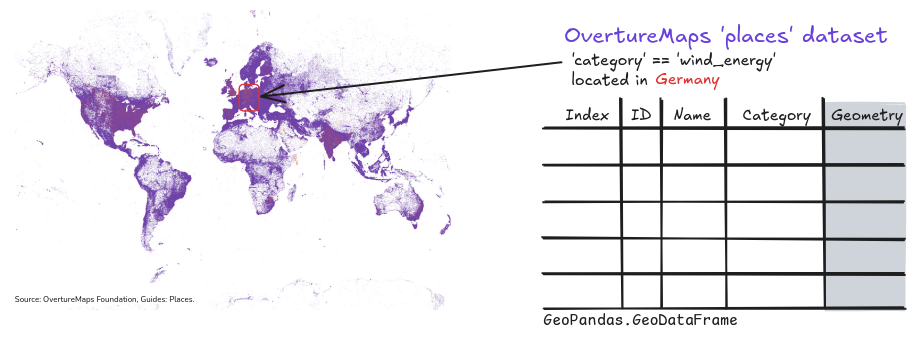

In [13]:
Image('imgs/overturemaps_dataframe_wmap.png')

In [14]:
# already here
ger_wind_query = f"""
      SELECT 
      id, 
      names.primary,
      categories.primary as category,
      ST_AsText(ST_GeomFromWKB(geometry)) as geometry
      FROM read_parquet("s3://overturemaps-us-west-2/release/2024-07-22.0/theme=places/type=place/*", hive_partitioning=1) as s3_table
      WHERE 
            categories.primary IN ('wind_energy')
            AND ST_Within(ST_GeomFromWKB(s3_table.geometry), ST_GeomFromText('{germany_wkt}'))
            
            """

In [15]:
ger_wind_gdf = overture_query(ger_wind_query)
ger_wind_gdf.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,id,primary,category,geometry
0,08f1fa355139106d038022d0afb88e55,Chauffages et Sanitaires Grethen Jos,wind_energy,POINT (6.30365 49.51271)
1,08f1fa3ceb98203003b3d967139ab3f9,Lënster Energie Sàrl,wind_energy,POINT (6.25885 49.69611)
2,08f1fa3195404a16035b92b7b79fa7eb,Bio Man,wind_energy,POINT (6.36202 49.66138)
3,08f1fa31b1a2e61503252c4163abc477,R & N - Reis & Neumann,wind_energy,POINT (6.37397 49.70882)
4,08f1faa6908e48b303b6fa2cef59118f,Stahl Windenergie GmbH,wind_energy,POINT (9.17882 48.58288)


## GeoDataFrame : the simplest vector data cube

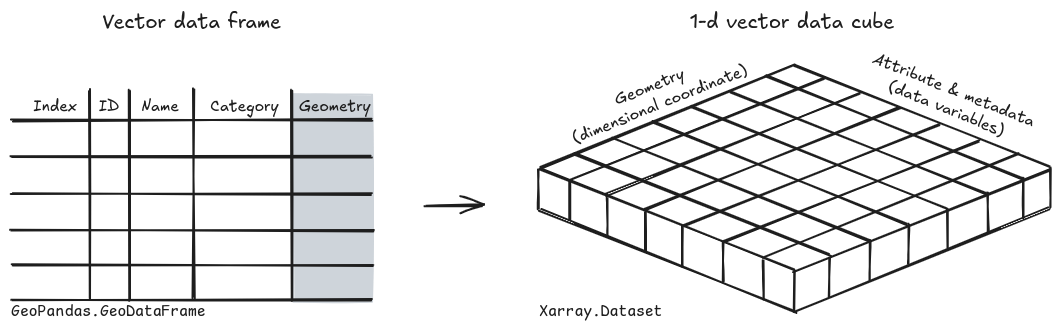

In [14]:
Image('imgs/vector_frame_to_1d_cube.png')

In [123]:
import xarray as xr
ger_wind_ds = xr.Dataset(
    {
        "primary": ("geometry", ger_wind_gdf["primary"]),
        "id": ("geometry", ger_wind_gdf["id"]),
    },
    coords={"geometry": ger_wind_gdf["geometry"]},
)
ger_wind_ds

<xarray.Dataset> Size: 504B
Dimensions:   (geometry: 21)
Coordinates:
  * geometry  (geometry) object 168B POINT (6.303651 49.512707) ... POINT (12...
Data variables:
    primary   (geometry) object 168B 'Chauffages et Sanitaires Grethen Jos' ....
    id        (geometry) object 168B '08f1fa355139106d038022d0afb88e55' ... '...

In [124]:
# set_geom
import xvec
ger_wind_ds = ger_wind_ds.xvec.set_geom_indexes('geometry', crs=ger_wind_gdf.crs)
ger_wind_ds

<xarray.Dataset> Size: 504B
Dimensions:   (geometry: 21)
Coordinates:
  * geometry  (geometry) object 168B POINT (6.303651 49.512707) ... POINT (12...
Data variables:
    primary   (geometry) object 168B 'Chauffages et Sanitaires Grethen Jos' ....
    id        (geometry) object 168B '08f1fa355139106d038022d0afb88e55' ... '...
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)

## Write to Zarr 

- Must first encode shapely geometries as CF geometries
- This Xvec method uses cf_xarray under the hood
- Why?
    - Shapely geometries have higher-order structures, they're not compatible with array file formats like Zarr
    - CF geometries deconstruct Shapely geometries to simpler structures, compatible with Zarr
        - Similar structure to GeoArrow geometries


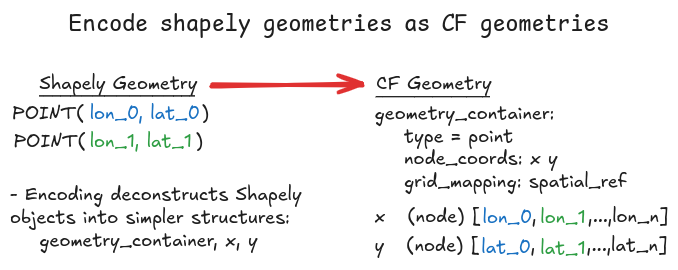

In [15]:
Image('imgs/encode_cf.png')

In [125]:
# encode cf
encoded_wind_ds = ger_wind_ds.xvec.encode_cf()
encoded_wind_ds

<xarray.Dataset> Size: 1kB
Dimensions:             (node: 21, geometry: 21)
Coordinates:
    spatial_ref         int64 8B 0
Dimensions without coordinates: node, geometry
Data variables:
    geometry_container  float64 8B nan
    x                   (node) float64 168B 6.304 6.259 6.362 ... 12.93 12.34
    y                   (node) float64 168B 49.51 49.7 49.66 ... 52.7 54.07
    lon                 (geometry) float64 168B 6.304 6.259 ... 12.93 12.34
    lat                 (geometry) float64 168B 49.51 49.7 49.66 ... 52.7 54.07
    primary             (geometry) object 168B 'Chauffages et Sanitaires Gret...
    id                  (geometry) object 168B '08f1fa355139106d038022d0afb88...

In [130]:
# Write zarr data to Arraylake Repo
encoded_wind_ds.to_zarr(repo.store, group='cube_1d', mode='w')

In [131]:
# commit changes
repo.commit('wrote 1d cube')

66cde6b96818e533b579271b

In [132]:
#tree
repo.tree()

Tree(nodes=(Node(name='/', nodes=(Node(name='cube_1d', nodes=(Node(icon='table', name='geometry_container () f…

### Read the vector data from Arraylake
- You can read vector data from Zarr stores!
- Roundtrip: Object read is identical to object written 

In [133]:
vec_cube_1d = repo.to_xarray('cube_1d')
vec_cube_1d

<xarray.Dataset> Size: 1kB
Dimensions:             (geometry: 21, node: 21)
Coordinates:
    lat                 (geometry) float64 168B ...
    lon                 (geometry) float64 168B ...
    spatial_ref         int64 8B ...
Dimensions without coordinates: geometry, node
Data variables:
    geometry_container  float64 8B ...
    id                  (geometry) object 168B ...
    primary             (geometry) object 168B ...
    x                   (node) float64 168B ...
    y                   (node) float64 168B ...

### Decode geometries from CF to Shapely

In [134]:
#decode
vec_cube_1d = vec_cube_1d.xvec.decode_cf()
vec_cube_1d

<xarray.Dataset> Size: 504B
Dimensions:   (geometry: 21)
Coordinates:
  * geometry  (geometry) object 168B POINT (6.303651 49.512707) ... POINT (12...
Data variables:
    id        (geometry) object 168B ...
    primary   (geometry) object 168B ...
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)

### Vector cube read from Zarr store is identical to the cube we created in memory

In [135]:
# check roundtrip
vec_cube_1d.identical(ger_wind_ds)

True

## Recap 

- With Xvec, possible to convert data from GeoParquet -> Xarray -> Zarr

- You can write the 1-d vector cube to a Zarr store, read it back into memory, and confirm that the object you read is identical to the object you wrote. 

## What's next?
Using vector data cubes and adding dimensions to vector cube

We haven't even touched on the dimensionality yet, which is the whole reason for vector cubes.

## Joining raster and vector data (Build multidimensional vector data cube)

We will use an ‘analysis-ready’ ERA5 data from [WeatherBench2](https://weatherbench2.readthedocs.io/en/latest/data-guide.html), which makes it possible to access ERA5 data from [Google Cloud Storage](https://cloud.google.com/storage?hl=en).

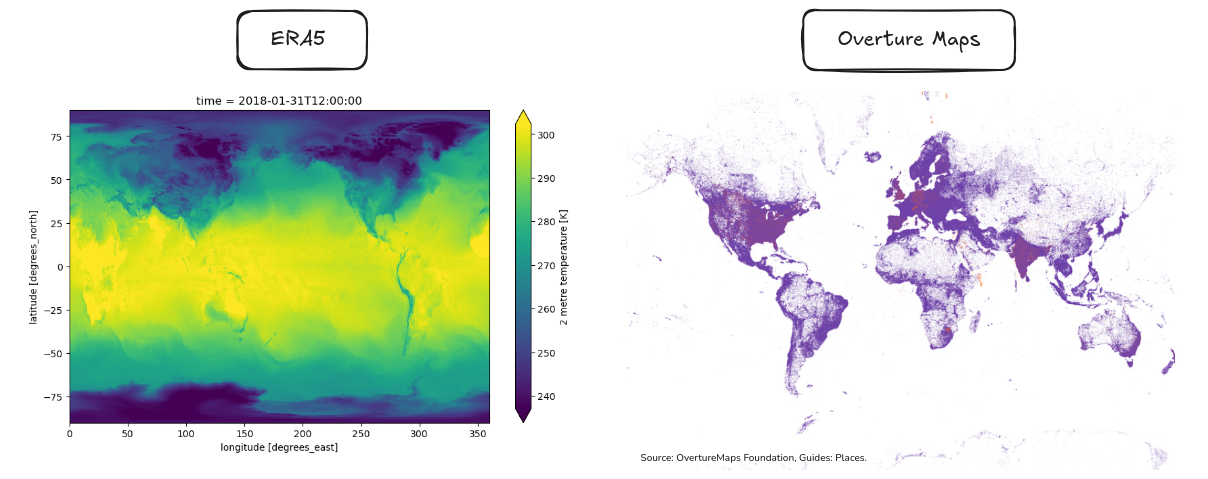

In [28]:
Image('imgs/overture_era5.png')

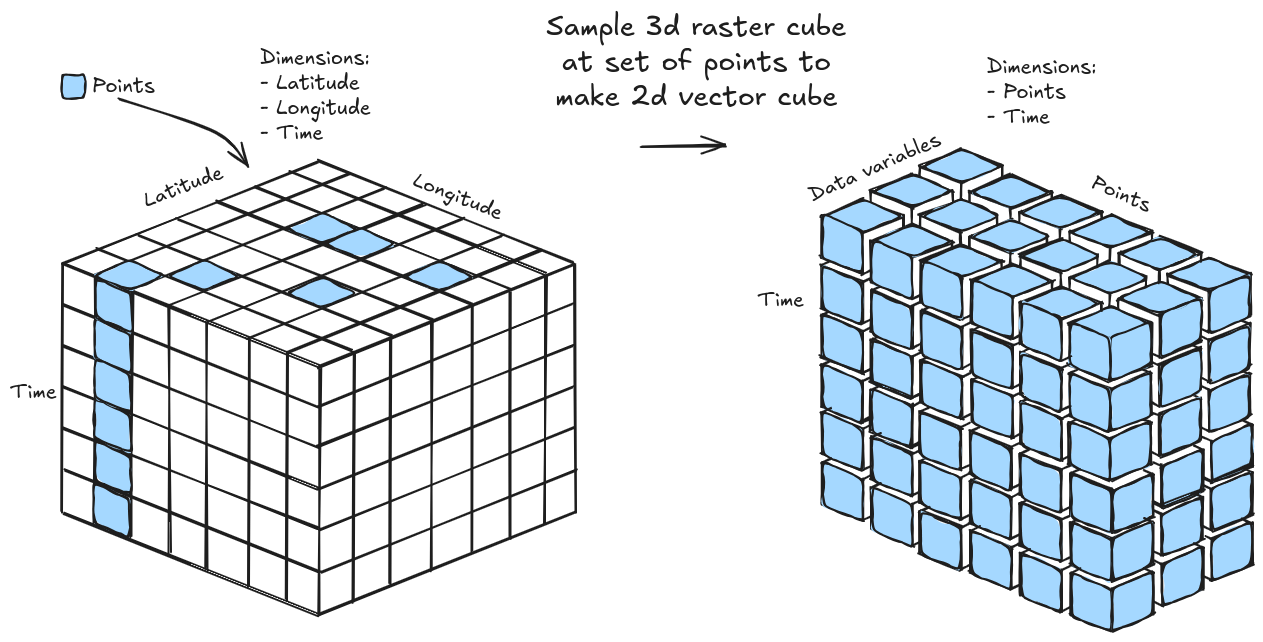

In [29]:
Image('imgs/raster_cube_to_vector_cube.png')

In [79]:
era5_uri = "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-6h-0p25deg-chunk-1.zarr-v2"

In [136]:
# read raster cube
raster_cube = read_era5_ds(era5_uri)
raster_cube

<xarray.Dataset> Size: 20GB
Dimensions:                  (time: 1584, latitude: 721, longitude: 1440)
Coordinates:
  * latitude                 (latitude) float32 3kB 90.0 89.75 ... -89.75 -90.0
  * time                     (time) datetime64[ns] 13kB 2019-01-01 ... 2020-0...
  * longitude                (longitude) float32 6kB -180.0 -179.8 ... 179.8
Data variables:
    2m_temperature           (time, latitude, longitude) float32 7GB dask.array<chunksize=(36, 721, 1440), meta=np.ndarray>
    u_component_of_wind      (time, latitude, longitude) float32 7GB dask.array<chunksize=(36, 721, 1440), meta=np.ndarray>
    10m_u_component_of_wind  (time, latitude, longitude) float32 7GB dask.array<chunksize=(36, 721, 1440), meta=np.ndarray>

### Sample the raster data cube at the set of vector geometries using [`xvec.extract_points()`](https://xvec.readthedocs.io/en/stable/extract_pts.html).

In [137]:
# extract points
vec_cube_2d = raster_cube.xvec.extract_points(
    vec_cube_1d.geometry, x_coords='longitude', y_coords='latitude')
vec_cube_2d

<xarray.Dataset> Size: 412kB
Dimensions:                  (time: 1584, geometry: 21)
Coordinates:
  * time                     (time) datetime64[ns] 13kB 2019-01-01 ... 2020-0...
  * geometry                 (geometry) object 168B POINT (6.303651 49.512707...
Data variables:
    2m_temperature           (time, geometry) float32 133kB dask.array<chunksize=(36, 21), meta=np.ndarray>
    u_component_of_wind      (time, geometry) float32 133kB dask.array<chunksize=(36, 21), meta=np.ndarray>
    10m_u_component_of_wind  (time, geometry) float32 133kB dask.array<chunksize=(36, 21), meta=np.ndarray>
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)

Load it into memory:

In [110]:
# slow so i've already run 
vec_cube_2d_mem = vec_cube_2d.load()


## Now, we can leverage both dimensions for computation and visualization:

This is a typical thing we want to do on the time dimension, it propagates the geometry information through the operation

In [138]:
#groupby 
vec_cube_2d_gb = vec_cube_2d_mem.groupby('time.season').mean()
vec_cube_2d_gb

<xarray.Dataset> Size: 1kB
Dimensions:                  (season: 4, geometry: 21)
Coordinates:
  * geometry                 (geometry) object 168B POINT (6.303651 49.512707...
  * season                   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    2m_temperature           (season, geometry) float32 336B 276.6 ... 283.3
    u_component_of_wind      (season, geometry) float32 336B 86.54 ... 46.86
    10m_u_component_of_wind  (season, geometry) float32 336B 1.091 ... 1.238
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)

### Visualize with GeoPandas

In [141]:
#explore
vec_cube_2d_gb.sel(season='DJF').xvec.to_geodataframe().explore('u_component_of_wind',
                                                              tiles='CartoDB dark_matter',
                                                              cmap='viridis')

We need to rechunk the dataset before it can be written to Zarr. After that, encode the geometries to CF-geometries, and write.

In [142]:
#rechunk, encode
vec_cube_2d_encoded = (
    # Chunk data
    vec_cube_2d_mem.chunk({"time": 48, "geometry": 26})
    # Encode geometries
    .xvec.encode_cf()
)


In [143]:
vec_cube_2d_encoded

<xarray.Dataset> Size: 413kB
Dimensions:                  (node: 21, geometry: 21, time: 1584)
Coordinates:
    spatial_ref              int64 8B 0
  * time                     (time) datetime64[ns] 13kB 2019-01-01 ... 2020-0...
Dimensions without coordinates: node, geometry
Data variables:
    geometry_container       float64 8B nan
    x                        (node) float64 168B 6.304 6.259 ... 12.93 12.34
    y                        (node) float64 168B 49.51 49.7 49.66 ... 52.7 54.07
    lon                      (geometry) float64 168B 6.304 6.259 ... 12.93 12.34
    lat                      (geometry) float64 168B 49.51 49.7 ... 52.7 54.07
    2m_temperature           (time, geometry) float32 133kB dask.array<chunksize=(48, 21), meta=np.ndarray>
    u_component_of_wind      (time, geometry) float32 133kB dask.array<chunksize=(48, 21), meta=np.ndarray>
    10m_u_component_of_wind  (time, geometry) float32 133kB dask.array<chunksize=(48, 21), meta=np.ndarray>

In [144]:
# write
vec_cube_2d_encoded.to_zarr(repo.store, group='cube_2d',mode='w')

In [145]:
# Commit changes
repo.commit('wrote 2d cube!')

66cde7ab3b0dcf28002826bb

In [146]:
#tree
repo.tree()

Tree(nodes=(Node(name='/', nodes=(Node(name='cube_2d', nodes=(Node(icon='table', name='2m_temperature (1584, 2…

### Let's look at size of this data as a `GeoDataFrame` v. as `Xr.Dataset` vector data cube:

In [147]:
# make gdf
gdf_long = vec_cube_2d_mem.xvec.to_geodataframe().reset_index()
gdf_long.head()

,time,geometry,2m_temperature,u_component_of_wind,10m_u_component_of_wind
0,2019-01-01,POINT (6.30365 49.51271),279.173553,36.669319,2.009340
1,2019-01-01,POINT (6.25885 49.69611),278.988556,37.152508,2.228703
2,2019-01-01,POINT (6.36202 49.66138),278.988556,37.152508,2.228703
3,2019-01-01,POINT (6.37397 49.70882),278.988556,37.152508,2.228703
4,2019-01-01,POINT (9.17882 48.58288),275.890411,30.958160,1.229466


## How does memory usage compare for n-d data as long-form vector dataframe v. vector data cube?

In [103]:
#memory usage gdf
gdf_long = vec_cube_2d_mem.xvec.to_geodataframe().reset_index()
gdf_long.head()

In [104]:
#memory usage cube
gdf_mem = gdf_long.memory_usage(index=False, deep=True).sum()
gdf_mem / 1e6 #size in megabytes

vec_cube_2d.nbytes / 1e6 #size in megabytes

# Back to slides